### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Get started with Video generation using Veo

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_Veo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

_If you're reading this notebook on Github, open it in Colab by clicking the above button to see the generated videos._

<!-- Princing warning Badge -->
<font color="red">⚠️ Veo is a paid only feature. This notebook won't run with the Free Tier.</font> (cf. <a href="https://ai.google.dev/pricing#veo2">pricing</a> for more details).

In [ ]:
# Change that value if you want to run the colab
I_am_aware_that_veo_is_a_paid_feature = False # @param {type:"boolean"}

## What's Veo?

Veo enables creators to create high quality videos with incredible detail, minimal artifacts, and extended durations in resolutions up to 1080p. Veo supports both text-to-video and images-to-video.

With [Veo 3](https://ai.google.dev/gemini-api/docs/video), you can create videos with:
* **Advanced language understanding**: Veo deeply understands natural language and visual semantics, capturing the nuance and tone of complex prompts to render intricate details in extended scenes, including cinematic terms like "timelapse" or "aerial shots."
* **Unprecedented creative control**: Veo provides an unprecedented level of creative control, understanding prompts for all kinds of cinematic effects, like timelapses or aerial shots of a landscape.
* **Videos with audio**: Veo 3 generates videos with audio automatically, with no additional effort from the developer.
* **More accurate video controls**: Veo 3 is more accurate on lighting, accurate physics, and camera controls.

**Veo 3.1** brings new capabilities:
* **Starting and ending frames**: Control how the video starts... and ends! ([jump directly to this part](#last_frame))
* **Image-based direction**: Give up to 3 references to Veo (character, locations, props...) and let it create a video using them ([jump directly to this part](#r2v))
* **Extend videos**: Add 7s more second to your videos up to 141 seconds long ones. ([jump directly to this part](#extend))

The Veo 3 family of models includes both [**Veo 3/3.1**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-3) as well as [**Veo 3/3.1 Fast**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-3-fast), which are a faster and more accessible version of the models. The Veo Fast models are ideal for backend services that programmatically generate ads, tools for rapid A/B testing of creative concepts, or apps that need to quickly produce social media content.

**Safety is a core focus**, with robust measures to prevent inappropriate or harmful content, and all generated videos are digitally watermarked with [Google DeepMind’s SynthID](https://deepmind.google/science/synthid/).

Note that the previous model generation, [**Veo 2**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-2), is still available for developers via the Gemini API for a while. However, unlike Veo 3, videos generated by Veo 2 do not contain audio.

# Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [ ]:
%pip install -U -q "google-genai>=1.44.0" # Minimum version 1.44 for video extension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.4 MB/s eta 0:00:00


### Setup your API key and initialize client

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata
from google import genai
from google.genai import types

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

### Select the Veo model

In [ ]:
VEO_MODEL_ID = "veo-3.1-fast-generate-preview" # @param ['veo-3.0-fast-generate-001', 'veo-3.0-generate-001', 'veo-3.1-fast-generate-preview', 'veo-3.1-generate-preview'] {"allow-input":true, isTemplate: true}

<a name="i2v"/>

# Text-to-video

Describe your desired scene, whether crafted by you or with Gemini's assistance, and Veo 3 brings it to life.

### Prompting Tips for Veo
To get the most out of Veo, consider incorporating specific video terminology into your prompts.  Veo understands a wide range of terms related to:

* **Shot composition**: Specify the framing and number of subjects in the shot (e.g., "*single shot*", "*two shot*", "*over-the-shoulder shot*").
* **Camera positioning and movement**:  Control the camera's location and movement using terms like "*eye level*", "*high angle*", "*worms eye*", "*dolly shot*", "*zoom shot*", "*pan shot," and "*tracking shot*".
* **Focus and lens effects**:  Use terms like "*shallow focus*", "*deep focus*", "*soft focus*", "*macro lens*", and "*wide-angle lens*" to achieve specific visual effects.
* **Overall style and subject**: Guide Veo's creative direction by specifying styles like "*sci-fi*", "*romantic comedy*", "*action movie*" or "*animation*". You can also describe the subjects and backgrounds you want, such as "*cityscape*", "*nature*", "*vehicles*", or "animals."

Check the [Veo prompt guide](https://ai.google.dev/gemini-api/docs/video#prompt-guide) for more details and tips.


### Optional parameters
The prompt is the only mandatory parameters, the others are all optional.

* **negative_prompt**: What you don't want to see in the video,
* **person_generation**: Tell you model if it's allowed to generate adults in the videos or not. Children are always blocked,
* **duration_seconds**: 4, 6 or 8s with Veo 3.1 (always 8s for Veo 3 and 7s when extending)
* **aspect ratio**: Either `16:9` (landscape) or `9:16` (portrait),
* **resolution**: Either `720p` or `1080p`

More details about each parameters in the related section of the [documentation](https://ai.google.dev/gemini-api/docs/video#veo-model-parameters).

### Create a video from a simple text prompt

It takes about a minute for the video to be generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "a close-up shot of a golden retriever playing in a field of sunflowers" # @param {type: "string"}

  # Optional parameters
  negative_prompt = "barking, woofing" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A golden retriever playing in a field of sunflowers](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dog_sunflowers.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dog_sunflowers.mp4">

### Select your resolution and aspect ratio

For landscape videos, you can select either the `720p` or the `1080p` resolutions. But if you prefer a vertical video you can set the `aspect_ratio` to `9:16` and get a portrait video.


In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "a unicorn takes off from the top of the arc de triomphe and fly to the Eiffel tower." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "airplanes" # @param {type: "string"}
  aspect_ratio = "9:16" # @param ["16:9","9:16"]
  resolution = "720p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A unicorn takes off from the top of the arc de triomphe and fly to the Eiffel tower.](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/unicorn.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/unicorn.mp4">

### Control the lighting

Veo 3 also allows you to have a good control on the lighing of the video being generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "a solitary, ancient oak tree silhouetted against a dramatic sunset. Emphasize the exquisite control over lighting: capture the deep, warm hues of the setting sun backlighting the tree, with subtle rays of light piercing through the branches, highlighting the texture of the bark and leaves with a golden glow. The sky should transition from fiery orange at the horizon to soft purples and blues overhead, with a single, faint star appearing as dusk deepens. Include the gentle sound of a breeze rustling through the leaves, and the distant call of an owl." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A solitary, ancient oak tree silhouetted against a dramatic sunset](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/lighting_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/lighting_control.mp4">

### Control the camera

Veo 3 also allows you to have a good control on the camera shots and behavior of the video being generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "a realistic video of a futuristic red sportscar speeding down a winding coastal highway at dusk. Begin with a high-angle drone shot that slowly descends, transitioning into a close-up, low-angle tracking shot that perfectly follows the car as it rounds a curve, emphasizing its speed and the gleam of its paint under the fading light. Then, execute a smooth, rapid dolly zoom, making the background compress as the car remains the same size, conveying a sense of intense focus and speed. Finally, end with a perfectly stable, slow-motion shot from a fixed roadside perspective as the car blurs past, its taillights streaking across the frame. Include the immersive sound of the engine roaring, the tires gripping the asphalt, and the distant crash of waves." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [a futuristic red sportscar speeding down a winding coastal highway](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/camera_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/camera_control.mp4">

### Control the audio

Veo 3 also allows you to control audio details on your generated video.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "fireworks at a beautiful city skyline scene with many different fireworks colors and sounds. sounds from excited people enjoying the show surrounding the camera POV can be heard too." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [fireworks at a beautiful city skyline scene](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/audio_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/audio_control.mp4">

### Manage your dialogs

You have the flexibility to define the dialog on your videos too.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "Two charismatic and funny raindrops like coloured characters. The first character start saying \"oh my god, it is really hot in here!\" - then the second answers \"right? I'm melting down! then it melts down completely." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "texts, captions, subtitles" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A dialog of two charismatic and funny raindrops like coloured characters](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dialog_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dialog_control.mp4">

<a name="i2v"/>

# Image-to-video
You can also generate videos from an base image and a prompt. Here are three examples, one in which you provide the image and one in which you will use Gemini Flash Image to generate the image. The [last one](#r2c) will mix multiple reference images into a video!


### Use your own images

If you want to use your own image, upload it to colab by clicking on the **folder icon** in the left menu (it should be the 5th choice), then on the **upload icon** (the first one) at the top of left left panel that should have been opened.

Your images will be uploaded in the `/content` folder of this colab instance.

Alternatively, you can use the code in this cell to upload your image:

In [ ]:
import os

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  os.rename(fn, 'image.jpg')

Saving ginger.jpeg to ginger.jpeg


Now that you have your own image, you can add it to your Veo prompt.

If you don't know what to prompt about your image, keep the prompt empty and the model will figure out what to generate.


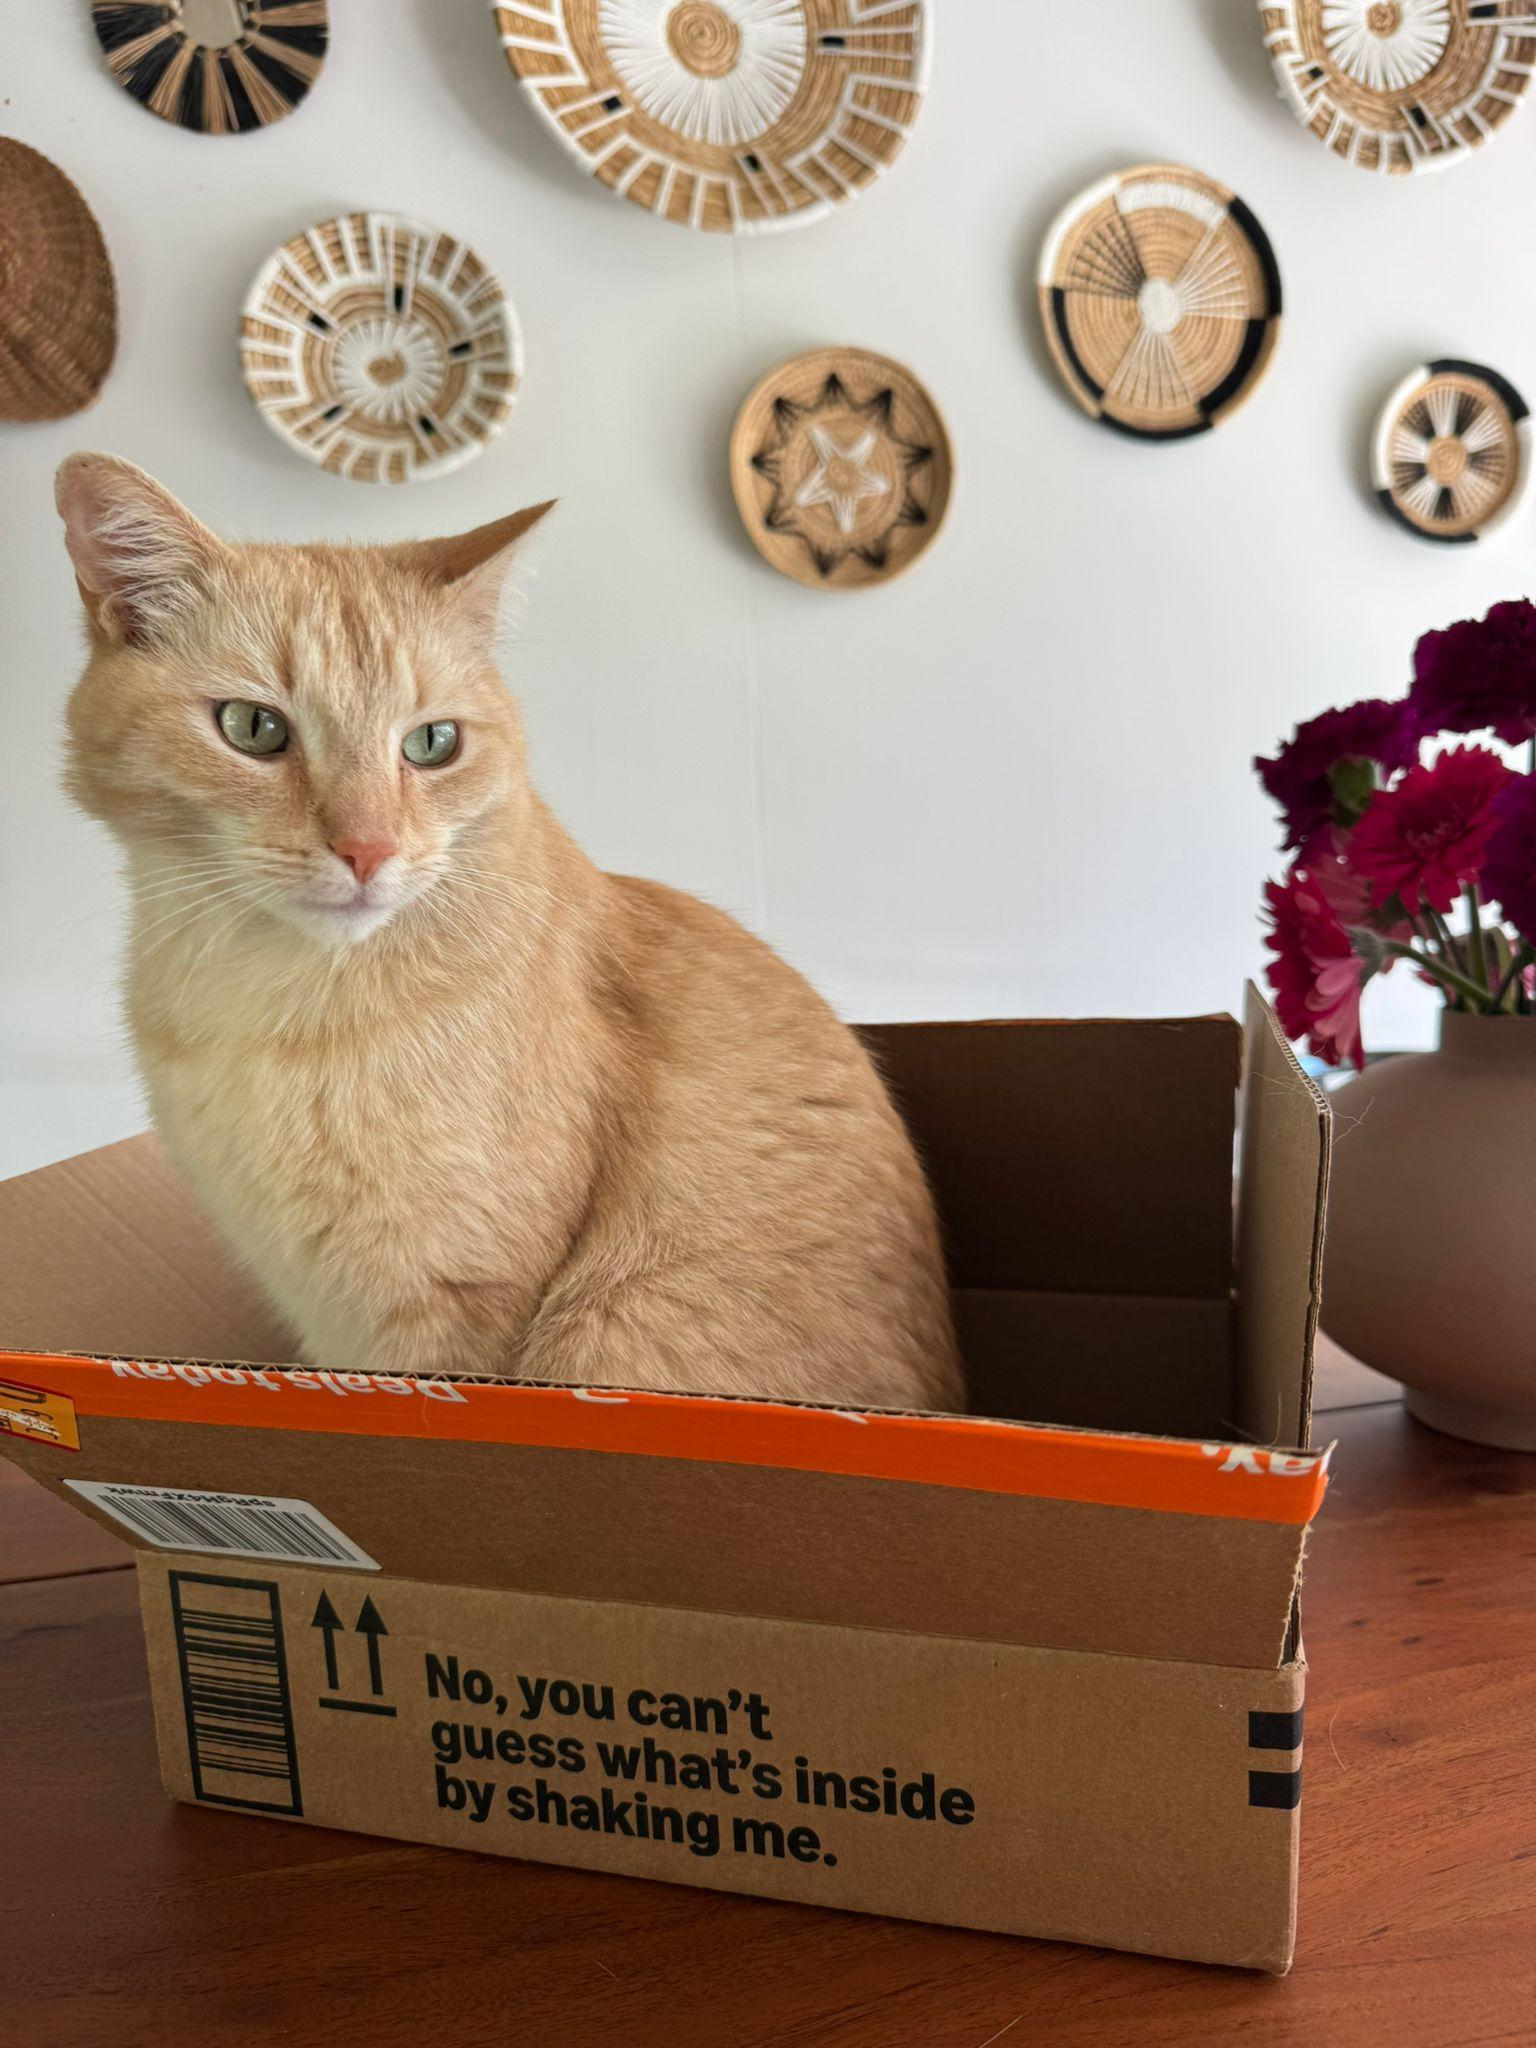

In [ ]:
from IPython.display import Image as Img

display(Img('image.jpg', width=600)) # display the uploaded image

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from PIL import Image
  import io

  prompt = "" # @param {"type":"string","placeholder":"Write your own prompt or leave empty to let the model decide"}
  image_name = "" # @param {type: "string", "placeholder":"Enter the name of your image or leave empty for the one you just uploaded."}

  # Optional parameters
  negative_prompt = "ugly, low quality" # @param {type: "string"}
  aspect_ratio = "9:16" # @param ["16:9","9:16"]
  resolution = "720p" # @param ["720p","1080p"]

  # Loading the image
  if image_name=="":
    image_name = "image.jpg"
  im = Image.open(image_name)

  # converting the image to bytes
  image_bytes_io = io.BytesIO()
  im.save(image_bytes_io, format=im.format)
  image_bytes = image_bytes_io.getvalue()

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=types.Image(image_bytes=image_bytes, mime_type=im.format),
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated from the uploaded image](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_img.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_img.mp4">

### Use Gemini Image to generate the base image

This time you're going to generate a base image with Gemini Image and, when happy with it, create a video out of it.

If you want to know more about Gemini native image-generation capability, check out the [dedicated notebook](./Get_Started_Nano_Banana.ipynb).

<font color=red>⚠️ Be careful, Image generation is a paid only feature (cf. <a href="https://ai.google.dev/gemini-api/docs/pricing#gemini-2.5-flash-image">pricing</a>).</font>

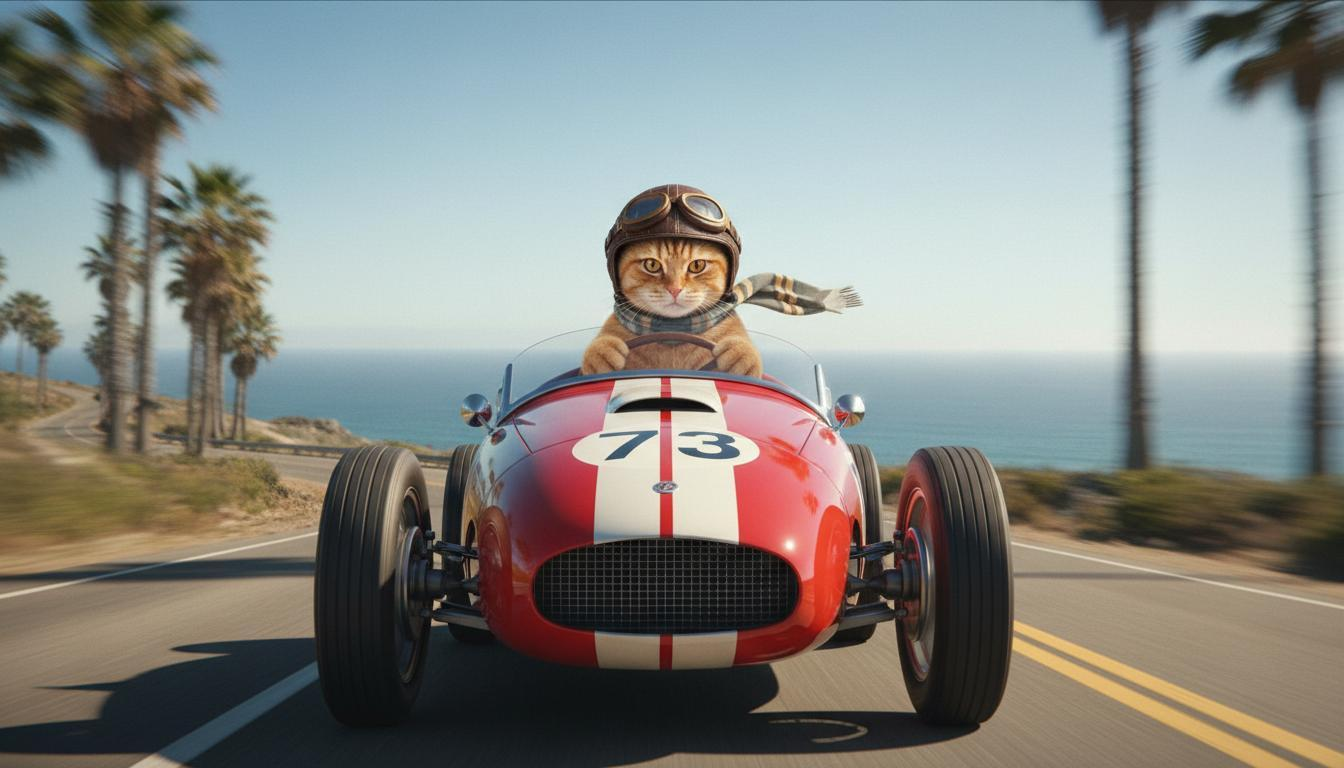

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Image generation is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  prompt = "A high quality photorealistic front image of a ginger cat driving a red convertible racing car on the French riviera coast"  # @param {type: "string"}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param {type: "string"}
  number_of_videos = 1

  response = client.models.generate_content(
      model="gemini-2.5-flash-image",
      contents=[prompt],
      config=types.GenerateContentConfig(
          response_modalities=["IMAGE"],
          image_config=types.ImageConfig(
              aspect_ratio=aspect_ratio,
          )
      )
  )

  for part in response.parts:
      if part.inline_data:
          gemini_image = part.as_image()
          break
  gemini_image.show()
  gemini_image.save("cat_car.png")

When you are happy with your image, you can use Veo to make a video out of it.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "The car races along the coast as the cat purrs in delight"  # @param {type: "string"}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=gemini_image,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Display the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated from the Gemini generated image](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_nanobanana_img.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_nanobanana_img.mp4">

<a name="last_frame"/>

### Add an ending image

Let's now add an ending image to control how the video should end. This can be used to make sure the video will blend with your existing content.

Note that you cannot use only an ending image, you always need to also add a starting one.

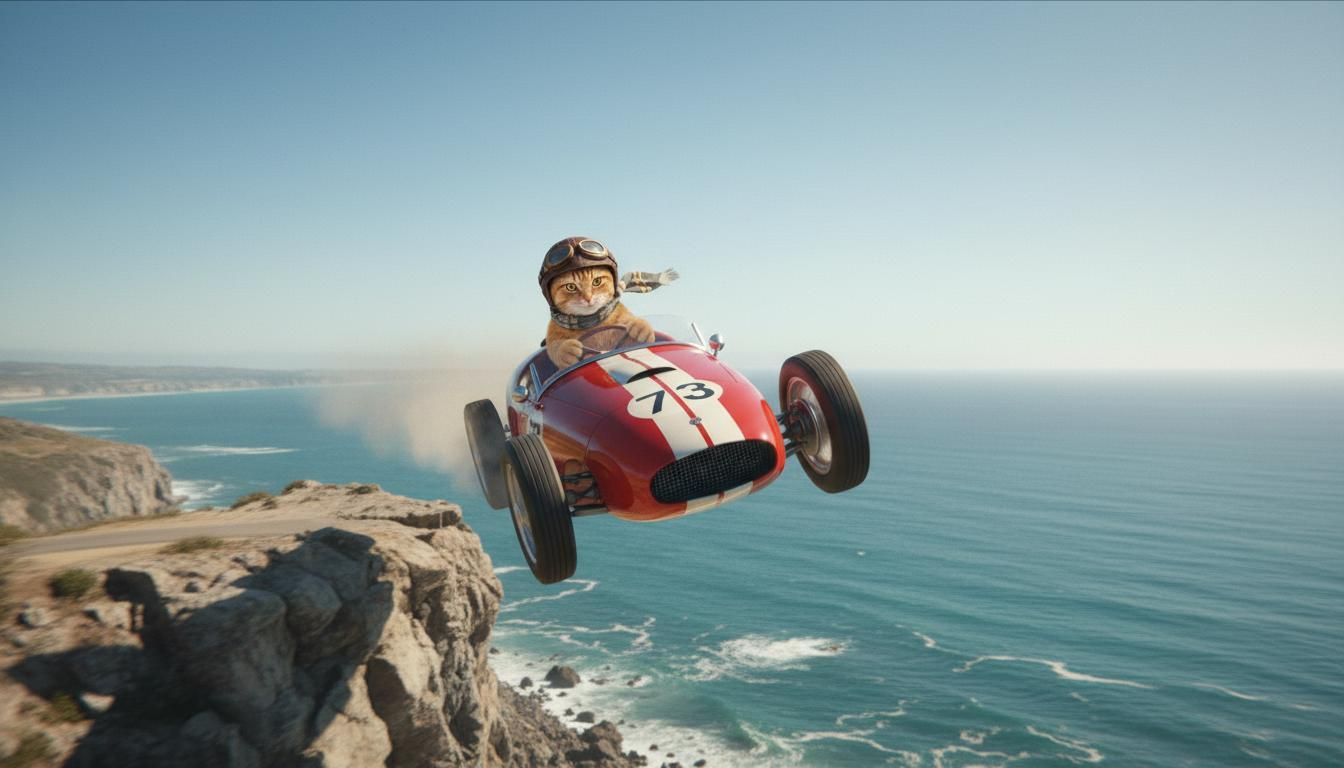

In [ ]:
import PIL

if not I_am_aware_that_veo_is_a_paid_feature:
  print("Image generation is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  prompt = "Show what happens afterwards when the car take off from a cliff."  # @param {type: "string"}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param {type: "string"}

  response = client.models.generate_content(
      model="gemini-2.5-flash-image",
      contents=[prompt, PIL.Image.open("cat_car.png")],
      config=types.GenerateContentConfig(
          response_modalities=["IMAGE"],
          image_config=types.ImageConfig(
              aspect_ratio=aspect_ratio,
          )
      )
  )

  for part in response.parts:
      if part.inline_data:
          ending_image = part.as_image()
          break
ending_image.show()

When you are happy with your ending image, you can use Veo to make a video bridging between your two images. You just need to pass the ending image using `config.last_frame` as you can see below:

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  # Optional parameters
  prompt = "" # @param {"type":"string","placeholder":"Prompt is optional here"}
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=gemini_image,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
        last_frame=ending_image
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'flying_car_{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Display the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated with a starting and ending frame](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_with_ending_frame.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_with_ending_frame.mp4">

<a name="r2v"/>

## References-to-video

You can also send multiple reference images to the model, they can be characters or objects that you want to see in the video or a style that you want to adhere to.

Note that it's only available using Veo 3.1 (not Fast) and in 720p and landscape (16:9).

### Add multiple references to your videos

Let's start by generating a couple of reference images.

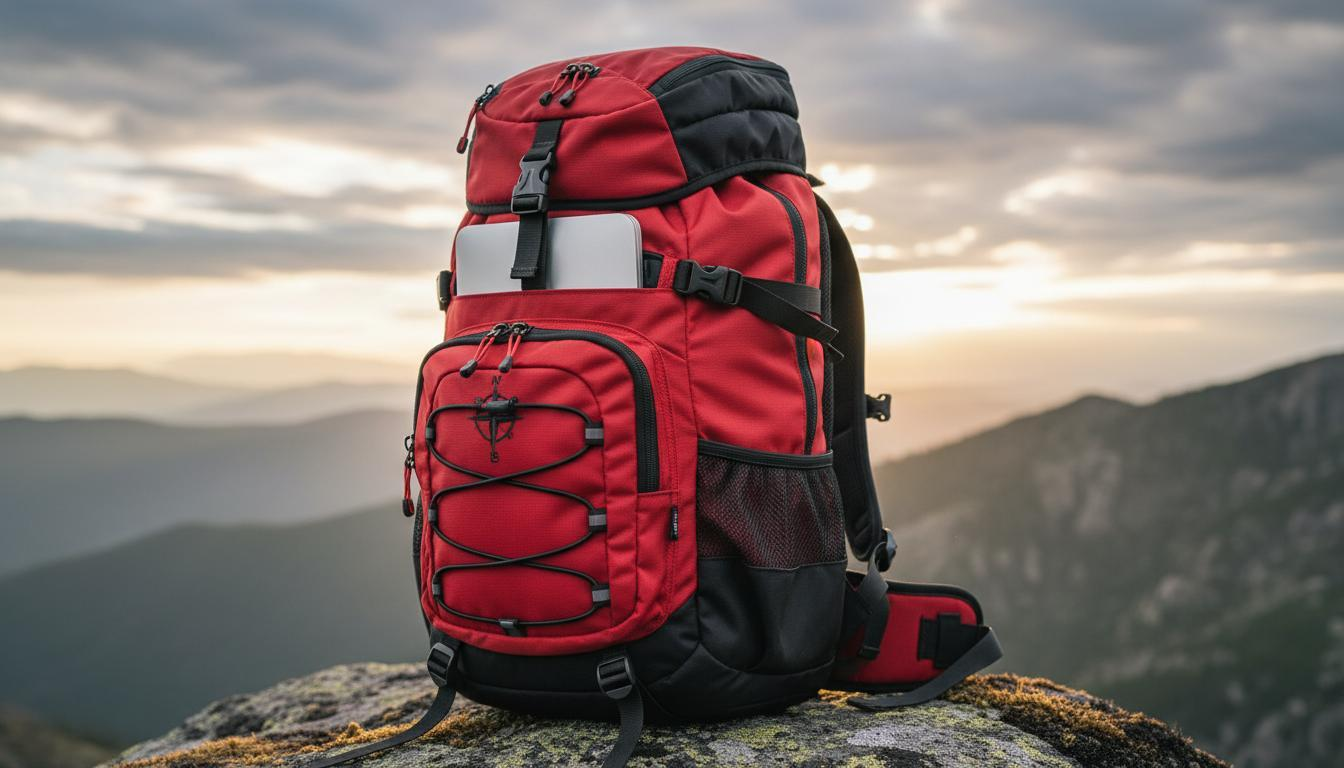

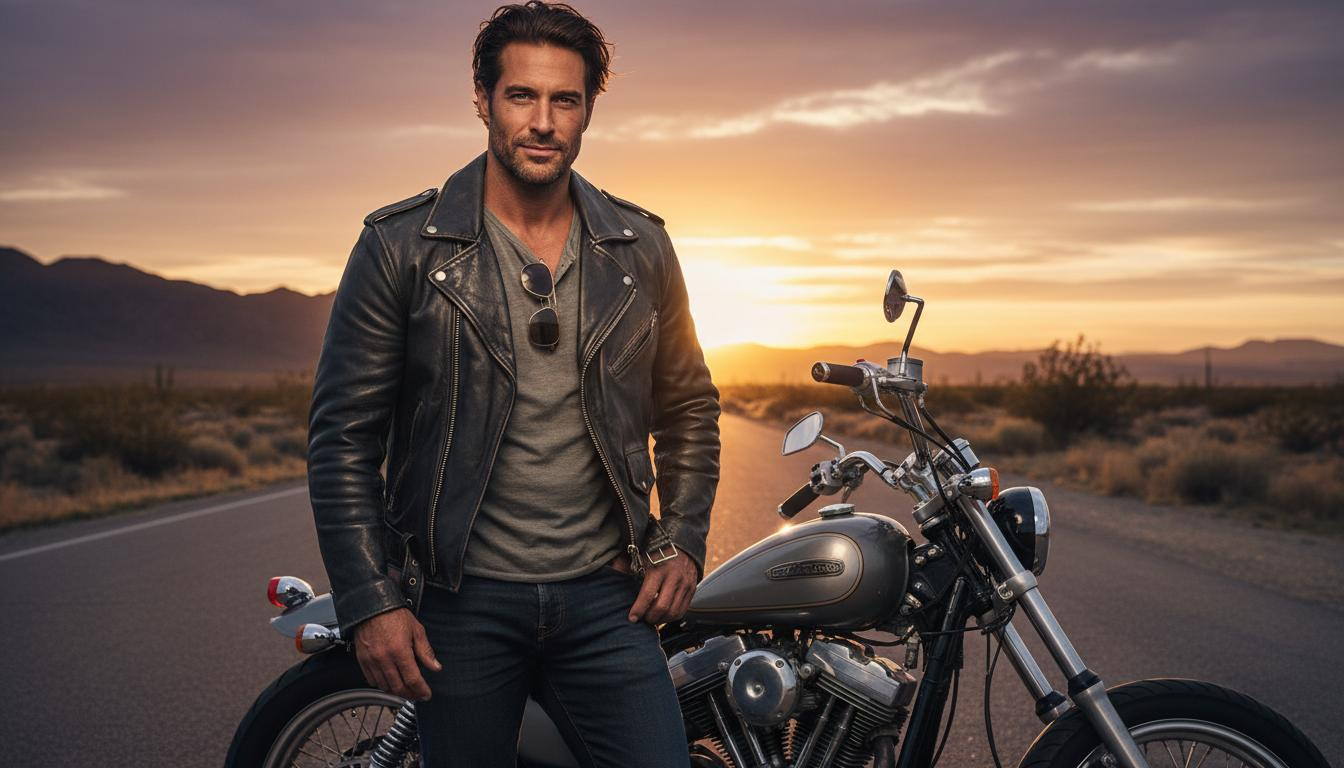

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Image generation is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  response = client.models.generate_content(
      model="gemini-2.5-flash-image",
      contents=["A red and black backpack"],
      config=types.GenerateContentConfig(
          response_modalities=["IMAGE"],
          image_config=types.ImageConfig(
              aspect_ratio=aspect_ratio,
          )
      )
  )
  for part in response.parts:
      if part.inline_data:
          backpack_image = part.as_image()
          break
  backpack_image.show()

  response = client.models.generate_content(
      model="gemini-2.5-flash-image",
      contents=["Tanned guy in a leather jacket and a motorbike"],
      config=types.GenerateContentConfig(
          response_modalities=["IMAGE"],
          image_config=types.ImageConfig(
              aspect_ratio=aspect_ratio,
          )
      )
  )
  for part in response.parts:
      if part.inline_data:
          actor_image = part.as_image()
          break
  actor_image.show()

Now create a video using those two reference images. Note that you need to convert your images into a `VideoGenerationReferenceImage` and indicate that they are assets.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time

  prompt = "A caricatural commercial video for this backpack. The actor puts on the backpack, jumps on his motorbike and starts off with a bang and an epic music" # @param {"type":"string","placeholder":"Write your own prompt or leave empty to let the model decide"}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9"] # Only landscape is supported
  resolution = "720p" # @param ["720p"] # Only 720p is supported

  backpack_reference = types.VideoGenerationReferenceImage(
    image=backpack_image,
    reference_type="asset"
  )

  actor_reference = types.VideoGenerationReferenceImage(
    image=actor_image,
    reference_type="asset"
  )

  operation = client.models.generate_videos(
      model="veo-3.1-generate-preview", # Reference to video only wirk with Veo 3.1 at the moment
      prompt=prompt,
      config=types.GenerateVideosConfig(
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        negative_prompt=negative_prompt,
        reference_images=[backpack_reference, actor_reference],
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Display the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated from multiple images](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/references_to_video.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/references_to_video.mp4">

<a name="extend"/>

# Extend videos (WIP)

You can also pass a video to extend it by 7s. It can be done multiple times, or starting with a video longer than 8s The main contraint is that the final video duration can only be **up to 148 seconds long** which means you can extent your first 8s video about 20 times.

The contraints on the video you want to extend are:
* Only with 720p resolution
* The input video must be Veo generated
* Less that 141s long

You just need to pass it using the `video` parameter.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
        negative_prompt=negative_prompt,
  import time

  prompt = "" # @param {"type":"string","placeholder":"Prompt is optional."}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      video=generated_video.video,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        number_of_videos=1,
        resolution="720p"
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Display the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 Here's a video that has been extended multiple times: [A cat's car takes to the air, multiple times](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/multi-extended_video.mp4)


<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/multi-extended_video.mp4">


# Next Steps
### Useful API references:

Check the [Veo documentation](https://ai.google.dev/gemini-api/docs/video) and the [prompt guide](https://ai.google.dev/gemini-api/docs/video#prompt-guide) for more details on how to use Veo and best prompt it.

### Continue your discovery of the Gemini API

Here are other cool Gemini features that you might find interesting:
* Gemini's [Image-out](./Image-out.ipynb) built-in image output can generate images with fine details, and let you iterate on them by chatting with the model;
* [Imagen](./Get_started_Imagen.ipynb) can also generate images ;
* Built-in [Audio-out](./Audio-out.ipynb) is also a great multimodal output capability that's quite fun to play with.

In [ ]:
# To prevent you from running the notebook by mistake
I_am_aware_that_veo_is_a_paid_feature = False